In [279]:
import numpy as np
import pandas as pd
from copy import deepcopy

from sklearn.neighbors import BallTree

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import shap

# Loading Data

In [80]:
def load_csv(name : str):
    return pd.read_csv(f"../data/{name}.csv")

In [81]:
data_df = load_csv("bicikelj_train")
data_df["timestamp"] = pd.to_datetime(data_df["timestamp"], format="%Y-%m-%dT%H:%MZ")
data_df.set_index("timestamp", inplace=True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20463 entries, 2022-09-01 09:00:00 to 2024-12-31 23:00:00
Data columns (total 84 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   LIDL BEŽIGRAD                         20453 non-null  float64
 1   ŠMARTINSKI PARK                       20453 non-null  float64
 2   SAVSKO NASELJE 1-ŠMARTINSKA CESTA     20453 non-null  float64
 3   ČRNUČE                                20453 non-null  float64
 4   VILHARJEVA CESTA                      20453 non-null  float64
 5   MASARYKOVA DDC                        20453 non-null  float64
 6   POGAČARJEV TRG-TRŽNICA                20453 non-null  float64
 7   CANKARJEVA UL.-NAMA                   20453 non-null  float64
 8   ANTONOV TRG                           20453 non-null  float64
 9   PRUŠNIKOVA                            20453 non-null  float64
 10  TEHNOLOŠKI PARK                       20453 non

In [82]:
holiday_df = load_csv("holiday_data")
holiday_df["timestamp"] = pd.to_datetime(holiday_df["timestamp"], format="%Y-%m-%dT%H:%MZ")
holidays = np.array(holiday_df["timestamp"].dt.date)
holidays

array([datetime.date(2022, 1, 1), datetime.date(2022, 1, 2),
       datetime.date(2022, 2, 8), datetime.date(2022, 4, 17),
       datetime.date(2022, 4, 18), datetime.date(2022, 4, 27),
       datetime.date(2022, 5, 1), datetime.date(2022, 5, 2),
       datetime.date(2022, 6, 5), datetime.date(2022, 6, 25),
       datetime.date(2022, 8, 15), datetime.date(2022, 10, 31),
       datetime.date(2022, 11, 1), datetime.date(2022, 12, 25),
       datetime.date(2022, 12, 26), datetime.date(2023, 1, 1),
       datetime.date(2023, 1, 2), datetime.date(2023, 2, 8),
       datetime.date(2023, 4, 9), datetime.date(2023, 4, 10),
       datetime.date(2023, 4, 27), datetime.date(2023, 5, 1),
       datetime.date(2023, 5, 2), datetime.date(2023, 5, 28),
       datetime.date(2023, 6, 25), datetime.date(2023, 8, 15),
       datetime.date(2023, 10, 31), datetime.date(2023, 11, 1),
       datetime.date(2023, 12, 25), datetime.date(2023, 12, 26),
       datetime.date(2024, 1, 1), datetime.date(2024, 1, 2),


In [83]:
meta_df = load_csv("bicikelj_metadata")
meta_df.set_index("name", inplace=True)
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84 entries, LIDL BEŽIGRAD to PLEČNIKOV STADION
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   84 non-null     float64
 1   longitude  84 non-null     float64
dtypes: float64(2)
memory usage: 2.0+ KB


In [84]:
weather_df = load_csv("weather_data")
weather_df["timestamp"] = pd.to_datetime(weather_df["timestamp"], format="%Y-%m-%dT%H:%MZ")
weather_df.set_index("timestamp", inplace=True)
weather_columns = weather_df.columns.to_numpy()
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23808 entries, 2022-09-01 00:00:00 to 2025-05-19 23:00:00
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temperature    23808 non-null  float64
 1   precipitation  23808 non-null  float64
 2   wind_speed     23808 non-null  float64
dtypes: float64(3)
memory usage: 744.0 KB


# Preprocessing

In [85]:
data_df[data_df.isna().any(axis=1)]

,LIDL BEŽIGRAD,ŠMARTINSKI PARK,SAVSKO NASELJE 1-ŠMARTINSKA CESTA,ČRNUČE,VILHARJEVA CESTA,MASARYKOVA DDC,POGAČARJEV TRG-TRŽNICA,CANKARJEVA UL.-NAMA,ANTONOV TRG,PRUŠNIKOVA,...,BTC CITY ATLANTIS,IKEA,MIKLOŠIČEV PARK,BARJANSKA C.-CENTER STAREJŠIH TRNOVO,LEK - VEROVŠKOVA,AMBROŽEV TRG,VOJKOVA - GASILSKA BRIGADA,RAKOVNIK,PREGLOV TRG,PLEČNIKOV STADION
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-11-04 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-01 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-22 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-03 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-31 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-05 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-06 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-16 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
data_df.interpolate(method="linear", inplace=True)

In [87]:
data_df.isna().sum()

LIDL BEŽIGRAD                        0
ŠMARTINSKI PARK                      0
SAVSKO NASELJE 1-ŠMARTINSKA CESTA    0
ČRNUČE                               0
VILHARJEVA CESTA                     0
                                    ..
AMBROŽEV TRG                         0
VOJKOVA - GASILSKA BRIGADA           0
RAKOVNIK                             0
PREGLOV TRG                          0
PLEČNIKOV STADION                    0
Length: 84, dtype: int64

In [88]:
station_names = data_df.columns.to_numpy()
station_names

array(['LIDL BEŽIGRAD', 'ŠMARTINSKI PARK',
       'SAVSKO NASELJE 1-ŠMARTINSKA CESTA', 'ČRNUČE', 'VILHARJEVA CESTA',
       'MASARYKOVA DDC', 'POGAČARJEV TRG-TRŽNICA', 'CANKARJEVA UL.-NAMA',
       'ANTONOV TRG', 'PRUŠNIKOVA', 'TEHNOLOŠKI PARK', 'KOSEŠKI BAJER',
       'TIVOLI', 'TRŽNICA MOSTE', 'GRUDNOVO NABREŽJE-KARLOVŠKA C.',
       'LIDL-LITIJSKA CESTA', 'ŠPORTNI CENTER STOŽICE', 'ŠPICA',
       'ROŠKA - STRELIŠKA', 'BAVARSKI DVOR', 'STARA CERKEV', 'SITULA',
       'ILIRSKA ULICA', 'LIDL - RUDNIK', 'KOPALIŠČE KOLEZIJA',
       'POVŠETOVA - KAJUHOVA', 'DUNAJSKA C.-PS MERCATOR', 'CITYPARK',
       'KOPRSKA ULICA', 'LIDL - VOJKOVA CESTA', 'POLJANSKA-POTOČNIKOVA',
       'POVŠETOVA-GRABLOVIČEVA', 'PARK NAVJE-ŽELEZNA CESTA', 'ZALOG',
       'CESTA NA ROŽNIK', 'HOFER-KAJUHOVA', 'DUNAJSKA C.-PS PETROL',
       'STUDENEC', 'PARKIRIŠČE NUK 2-FF', 'BRATOVŠEVA PLOŠČAD',
       'KONGRESNI TRG-ŠUBIČEVA ULICA', 'BS4-STOŽICE',
       'GERBIČEVA - ŠPORTNI PARK SVOBODA', 'ŽIVALSKI VRT',
       'VOK

In [89]:
temporal_columns = np.array(["hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos", "is_weekend", "is_holiday"])

def prepare_dataframe(df):
    df["hour_sin"] =  np.sin(df.index.hour *    (2 * np.pi / 24))
    df["hour_cos"] =  np.cos(df.index.hour *    (2 * np.pi / 24))
    df["dow_sin"] =   np.sin(df.index.weekday * (2 * np.pi / 7 ))
    df["dow_cos"] =   np.cos(df.index.weekday * (2 * np.pi / 7 ))
    df["month_sin"] = np.sin(df.index.month *   (2 * np.pi / 12))
    df["month_cos"] = np.cos(df.index.month *   (2 * np.pi / 12))

    df["is_weekend"] = (df.index.weekday == 5) | (df.index.weekday == 6)
    df["is_weekend"] = df["is_weekend"].astype(float)

    df["is_holiday"] = np.isin(df.index.date, holidays)
    df["is_holiday"] = df["is_holiday"].astype(float)
    
    df = df.join(weather_df)
    return df

In [90]:
data_df = prepare_dataframe(data_df)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20463 entries, 2022-09-01 09:00:00 to 2024-12-31 23:00:00
Data columns (total 95 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   LIDL BEŽIGRAD                         20463 non-null  float64
 1   ŠMARTINSKI PARK                       20463 non-null  float64
 2   SAVSKO NASELJE 1-ŠMARTINSKA CESTA     20463 non-null  float64
 3   ČRNUČE                                20463 non-null  float64
 4   VILHARJEVA CESTA                      20463 non-null  float64
 5   MASARYKOVA DDC                        20463 non-null  float64
 6   POGAČARJEV TRG-TRŽNICA                20463 non-null  float64
 7   CANKARJEVA UL.-NAMA                   20463 non-null  float64
 8   ANTONOV TRG                           20463 non-null  float64
 9   PRUŠNIKOVA                            20463 non-null  float64
 10  TEHNOLOŠKI PARK                       20463 non

# Metadata Exploration

In [ ]:
coords = np.radians(meta_df[["latitude", "longitude"]].values)
tree = BallTree(coords, metric="haversine")
k = 3
_, idx = tree.query(coords, k=k)

neighbors = []
for i, name in enumerate(meta_df.index):
    nearest_indices = idx[i][1:]
    nearest_stations = meta_df.index[nearest_indices].tolist()
    neighbors.append(nearest_stations)

meta_df["neighbors"] = neighbors
    
meta_df.head()

,latitude,longitude,neighbors
name,,,
LIDL BEŽIGRAD,46.063797,14.506854,"[DUNAJSKA C.-PS PETROL, PARK NAVJE-ŽELEZNA CESTA]"
ŠMARTINSKI PARK,46.065206,14.529911,"[SAVSKO NASELJE 1-ŠMARTINSKA CESTA, IKEA]"
SAVSKO NASELJE 1-ŠMARTINSKA CESTA,46.062475,14.524321,"[SITULA, ŠMARTINSKI PARK]"
ČRNUČE,46.102446,14.530213,"[BRATOVŠEVA PLOŠČAD, BS4-STOŽICE]"
VILHARJEVA CESTA,46.060050,14.513020,"[MASARYKOVA DDC, TRG OF-KOLODVORSKA UL.]"


In [317]:
meta_df.reset_index().to_csv("../data/enriched_metadata.csv", index=False)

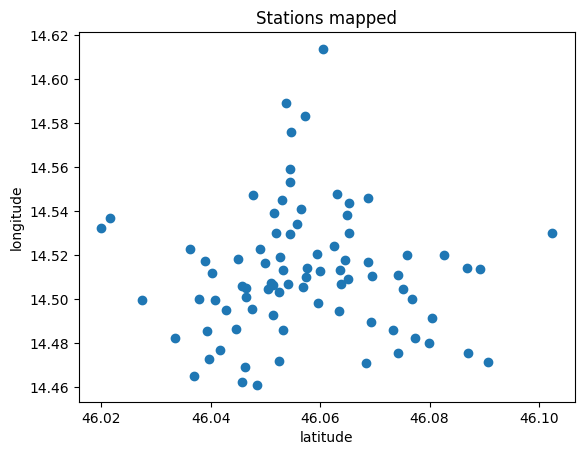

In [92]:
plt.title("Stations mapped")
plt.plot(meta_df["latitude"], meta_df["longitude"], "o")
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.show()

In [93]:
avg_latitude = meta_df["latitude"].mean()
avg_longitude = meta_df["longitude"].mean()
print(f"{avg_latitude:.4f}, {avg_longitude:.4f}")

46.0572, 14.5119


# Data Exploration

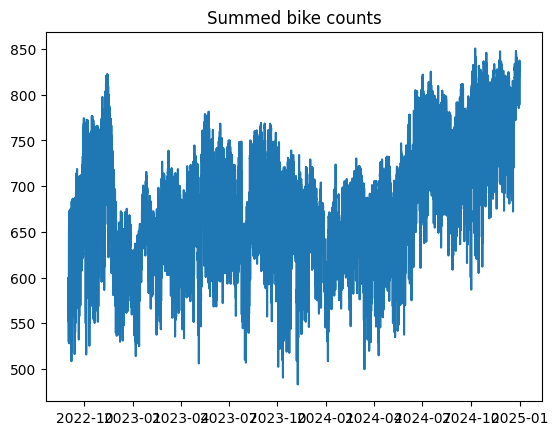

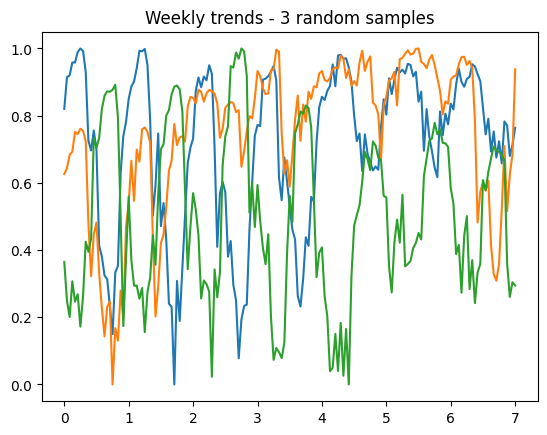

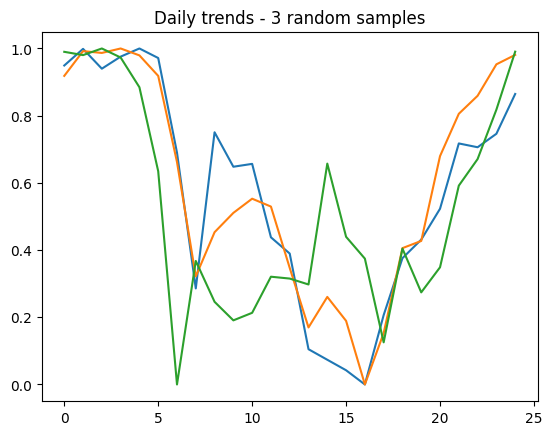

In [94]:
total_counts = data_df.sum(axis=1)

plt.title("Summed bike counts")
plt.plot(total_counts)
plt.show()

samples = 3
plt.title(f"Weekly trends - {samples} random samples")
mondays = total_counts.index[total_counts.index.weekday == 0]
for i in range(samples):
    random_monday = np.random.choice(mondays)
    random_counts = total_counts[random_monday:(random_monday + pd.DateOffset(days=7))]
    random_counts = (random_counts - random_counts.min()) / (random_counts - random_counts.min()).abs().max()
    plt.plot(range(24 * 7 + 1), random_counts)
    plt.xticks(range(0, 24 * 7 + 1, 24), range(0, 8))
plt.show()

samples = 3
plt.title(f"Daily trends - {samples} random samples")
days = total_counts.index[total_counts.index.hour == 0]
for i in range(samples):
    random_day = np.random.choice(days)
    random_counts = total_counts[random_day:(random_day + pd.DateOffset(hours=24))]
    random_counts = (random_counts - random_counts.min()) / (random_counts - random_counts.min()).abs().max()
    plt.plot(range(24 + 1), random_counts)
plt.show()

In [95]:
train_df_tm1 = data_df[station_names].shift(-1).add_suffix("_t-1")
train_df_tm1

joined_df = pd.concat([data_df[station_names], train_df_tm1], axis=1)[:-1]

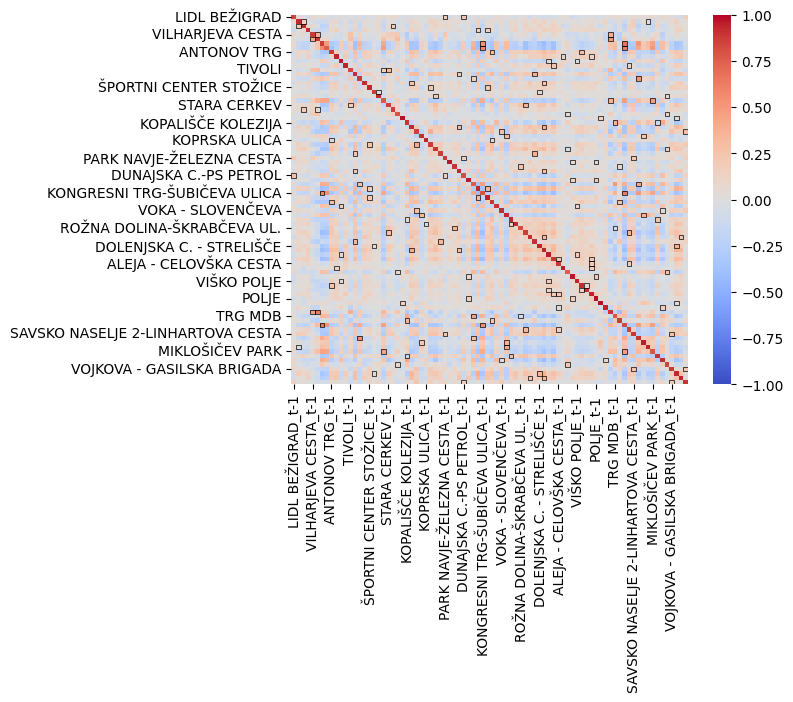

In [96]:
cross_corr = joined_df.corr(method="pearson")
cross_corr = cross_corr.loc[station_names, train_df_tm1.columns]

ax = sns.heatmap(cross_corr, annot=False, vmin=-1, vmax=1, cmap="coolwarm")

for station in station_names:
    row = meta_df.loc[station]
    row_i = meta_df.index.get_loc(station)
    for neighbor in row["neighbors"]:
        neighbor_i = meta_df.index.get_loc(neighbor)
        ax.add_patch(plt.Rectangle(
            (neighbor_i, row_i), 1, 1, fill=False, edgecolor="black", linewidth=0.5
        ))
    
plt.show()

# Data Split

In [97]:
train_end = int(len(data_df) * 0.8)
val_end = int(len(data_df) * 0.9)

train_df = data_df.iloc[:train_end].copy()
val_df = data_df.iloc[train_end:val_end].copy()
test_df = data_df.iloc[val_end:].copy()
len(train_df), len(val_df), len(test_df)

(16370, 2046, 2047)

In [314]:
station_names.tolist()

['LIDL BEŽIGRAD',
 'ŠMARTINSKI PARK',
 'SAVSKO NASELJE 1-ŠMARTINSKA CESTA',
 'ČRNUČE',
 'VILHARJEVA CESTA',
 'MASARYKOVA DDC',
 'POGAČARJEV TRG-TRŽNICA',
 'CANKARJEVA UL.-NAMA',
 'ANTONOV TRG',
 'PRUŠNIKOVA',
 'TEHNOLOŠKI PARK',
 'KOSEŠKI BAJER',
 'TIVOLI',
 'TRŽNICA MOSTE',
 'GRUDNOVO NABREŽJE-KARLOVŠKA C.',
 'LIDL-LITIJSKA CESTA',
 'ŠPORTNI CENTER STOŽICE',
 'ŠPICA',
 'ROŠKA - STRELIŠKA',
 'BAVARSKI DVOR',
 'STARA CERKEV',
 'SITULA',
 'ILIRSKA ULICA',
 'LIDL - RUDNIK',
 'KOPALIŠČE KOLEZIJA',
 'POVŠETOVA - KAJUHOVA',
 'DUNAJSKA C.-PS MERCATOR',
 'CITYPARK',
 'KOPRSKA ULICA',
 'LIDL - VOJKOVA CESTA',
 'POLJANSKA-POTOČNIKOVA',
 'POVŠETOVA-GRABLOVIČEVA',
 'PARK NAVJE-ŽELEZNA CESTA',
 'ZALOG',
 'CESTA NA ROŽNIK',
 'HOFER-KAJUHOVA',
 'DUNAJSKA C.-PS PETROL',
 'STUDENEC',
 'PARKIRIŠČE NUK 2-FF',
 'BRATOVŠEVA PLOŠČAD',
 'KONGRESNI TRG-ŠUBIČEVA ULICA',
 'BS4-STOŽICE',
 'GERBIČEVA - ŠPORTNI PARK SVOBODA',
 'ŽIVALSKI VRT',
 'VOKA - SLOVENČEVA',
 'BTC CITY/DVORANA A',
 'TRNOVO',
 'P+R BARJE',
 '

# Data Normalization

In [ ]:
station_means = train_df[station_names].mean()
station_stds = train_df[station_names].std()

weather_means = train_df[weather_columns].mean()
weather_stds = train_df[weather_columns].std()

In [319]:
station_means.to_csv("../data/station_means.csv")
station_stds.to_csv("../data/station_stds.csv")
weather_means.to_csv("../data/weather_means.csv")
weather_stds.to_csv("../data/weather_stds.csv")

In [99]:
def normalize(df):
    df[station_names] = (df[station_names] - station_means) / station_stds
    df[weather_columns] = (df[weather_columns] - weather_means) / weather_stds
    return df

In [100]:
def denormalize(df):
    df[station_names] = df[station_names] * station_stds + station_means
    return df

In [101]:
train_df = normalize(train_df)
val_df = normalize(val_df)
test_df = normalize(test_df)

In [102]:
train_df.head()

,LIDL BEŽIGRAD,ŠMARTINSKI PARK,SAVSKO NASELJE 1-ŠMARTINSKA CESTA,ČRNUČE,VILHARJEVA CESTA,MASARYKOVA DDC,POGAČARJEV TRG-TRŽNICA,CANKARJEVA UL.-NAMA,ANTONOV TRG,PRUŠNIKOVA,...,hour_cos,dow_sin,dow_cos,month_sin,month_cos,is_weekend,is_holiday,temperature,precipitation,wind_speed
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-09-01 09:00:00,0.731163,-1.076574,0.570853,-1.561103,-0.575761,-0.073581,0.648343,0.871205,-0.460466,0.004316,...,-0.707107,0.433884,-0.900969,-1.0,-1.836970e-16,0.0,0.0,0.988872,-0.24797,0.950549
2022-09-01 10:00:00,-0.111935,-1.467319,0.165432,-1.797314,-1.061776,-0.915139,0.177892,1.979872,0.387186,-0.210132,...,-0.866025,0.433884,-0.900969,-1.0,-1.836970e-16,0.0,0.0,1.153457,-0.24797,2.043569
2022-09-01 11:00:00,-0.322709,-0.881201,0.165432,-1.797314,-1.223781,-0.410204,1.432427,1.117576,0.387186,-0.210132,...,-0.965926,0.433884,-0.900969,-1.0,-1.836970e-16,0.0,0.0,1.196128,-0.24797,2.700538
2022-09-01 12:00:00,-0.533483,-0.490455,-0.442701,-1.324893,-0.413756,-1.083451,1.589244,0.624835,0.048125,-0.210132,...,-1.000000,0.433884,-0.900969,-1.0,-1.836970e-16,0.0,0.0,1.153457,-0.24797,2.752618
2022-09-01 13:00:00,-1.165807,0.681782,-0.037279,-1.324893,-0.251751,-1.083451,0.334709,1.610316,-0.121405,-0.424580,...,-0.965926,0.433884,-0.900969,-1.0,-1.836970e-16,0.0,0.0,1.147362,-0.24797,3.026052


# Constructing Station Datasets

# Models

In [296]:
class BicikeljDataset(Dataset):
    def __init__(self, df, station, training=True):

        if training:
            X_df, y_df, feature_count = BicikeljDataset._construct_training_dataframes(df, station)
            self.feature_count = feature_count
            self.X = torch.tensor(X_df.values, dtype=torch.float32)
            self.y = torch.tensor(y_df.values, dtype=torch.float32)

        else:
            X_df, feature_count = self._construct_testing_dataframes(df, station)
            self.X = torch.tensor(X_df.values, dtype=torch.float32)
            self.y = None
    
    @staticmethod
    def _construct_training_dataframes(df, station_name, max_lag=24):
        y_df = df[station_name]
        
        X_df = pd.DataFrame()
        for lag in range(1, max_lag + 1):
            X_df[f"{station_name}_t-{lag}"] = y_df.shift(lag)

        for neighbor in meta_df.loc[station_name]["neighbors"]:
            X_df[f"{neighbor}_t-1"] = df[neighbor].shift(1)
        
        X_df[temporal_columns] = df[temporal_columns]
        X_df[weather_columns] = df[weather_columns]

        y_df = pd.concat([y_df.shift(-i) for i in range(0, 1)], axis=1)
        y_df.columns = [f"t+i_{i}" for i in range(0, 1)]

        valid = X_df.notna().all(axis=1) & y_df.notna().all(axis=1)
        X_df = X_df[valid]
        y_df = y_df[valid]

        return X_df, y_df, X_df.shape[1]
    
    @staticmethod
    def _construct_testing_dataframes(df, station_name, max_lag=24):
        y_df = df[station_name]

        X_df = pd.DataFrame()

        for lag in range(1, max_lag + 1):
            X_df[f"{station_name}_t-{lag}"] = y_df.shift(lag)

        for neighbor in meta_df.loc[station_name]["neighbors"]:
            X_df[f"{neighbor}_t-1"] = df[neighbor].shift(1)

        X_df[temporal_columns] = df[temporal_columns]
        X_df[weather_columns] = df[weather_columns]

        X_df = X_df[X_df.notna().all(axis=1)]
        
        return X_df, X_df.shape[1]

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [104]:
class BicikeljDataloader:
    def __init__(self, df, shuffle):
        self.feature_count = 0
        self.datasets = {}
        self.loaders = {}
        for station in station_names:
            dataset = BicikeljDataset(df, station)
            self.datasets[station] = dataset
            self.feature_count = dataset.feature_count
            
            loader = DataLoader(dataset, batch_size=256, shuffle=shuffle)
            self.loaders[station] = loader
            
    def __getitem__(self, station):
        return self.loaders[station]

In [105]:
class BicikeljMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# Training

In [106]:
train_loaders = BicikeljDataloader(train_df, shuffle=True)
val_loaders = BicikeljDataloader(val_df, shuffle=False)
test_loaders = BicikeljDataloader(test_df, shuffle=False)

In [207]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 1337

np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

models = {station: BicikeljMLP(train_loaders.feature_count).to(device) for station in station_names}

validation_timestamps = val_df.iloc[[i for x in range(48, len(val_df), 48) for i in range(x, x+4)]].index
val_df_predictions = val_df.copy()

for i, station in enumerate(station_names):
    print(f"Training {station} ({i+1}/{len(station_names)})")

    model = models[station]
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    best_val = float("inf")
    best_weights = None
    patience = 5
    wait = 0
    min_delta = 1e-3
    max_epochs = 100

    for epoch in range(max_epochs):
        model.train()
        train_loss = 0

        for X_batch, y_batch in train_loaders[station]:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        predictions = []
        reals = []
        with torch.no_grad():
            for timestamp in validation_timestamps:
                sub_df = val_df_predictions.loc[:timestamp - pd.Timedelta(hours=1)].copy()

                dataset = BicikeljDataset(sub_df, station, training=False)
                X_test = dataset.X
                
                X_df = X_test[-1].unsqueeze(0)

                prediction = model(X_df).item()

                val_df_predictions.loc[timestamp, station] = prediction

                reals.append(val_df.loc[timestamp, station])
                predictions.append(prediction)

        predictions = np.array(predictions) * station_stds[station] + station_means[station]
        reals = np.array(reals) * station_stds[station] + station_means[station]
        
        val_loss = ((reals - predictions) ** 2).mean()

        if val_loss < best_val - min_delta:
            best_val = val_loss
            best_weights = {k: v.clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch} with val loss {val_loss:.2f}")
                break

        # if (epoch % 10 == 0):
        #    print(f"Epoch {epoch}: train loss: {train_loss:.2f}, val loss: {val_loss:.2f}")
    
    model.load_state_dict(best_weights)
    models[station] = model

    print(f"Finished training {station}")

Training LIDL BEŽIGRAD (1/84)
Early stopping at epoch 10 with val loss 17.75
Finished training LIDL BEŽIGRAD
Training ŠMARTINSKI PARK (2/84)
Early stopping at epoch 6 with val loss 12.75
Finished training ŠMARTINSKI PARK
Training SAVSKO NASELJE 1-ŠMARTINSKA CESTA (3/84)
Early stopping at epoch 5 with val loss 12.34
Finished training SAVSKO NASELJE 1-ŠMARTINSKA CESTA
Training ČRNUČE (4/84)
Early stopping at epoch 6 with val loss 17.76
Finished training ČRNUČE
Training VILHARJEVA CESTA (5/84)
Early stopping at epoch 9 with val loss 29.72
Finished training VILHARJEVA CESTA
Training MASARYKOVA DDC (6/84)
Early stopping at epoch 5 with val loss 22.32
Finished training MASARYKOVA DDC
Training POGAČARJEV TRG-TRŽNICA (7/84)
Early stopping at epoch 7 with val loss 22.66
Finished training POGAČARJEV TRG-TRŽNICA
Training CANKARJEVA UL.-NAMA (8/84)
Early stopping at epoch 7 with val loss 41.93
Finished training CANKARJEVA UL.-NAMA
Training ANTONOV TRG (9/84)
Early stopping at epoch 7 with val loss

In [213]:
for i, (station, model) in enumerate(models.items()):
    torch.save(model.state_dict(), f"../models/{i}.pth")

# Testing

In [220]:
mses = []

test_timestamps = test_df.iloc[[i for x in range(48, len(test_df), 48) for i in range(x, x+4)]].index
test_df_predictions = test_df.copy()

for station, model in models.items():
    model.eval()
    all_predictions = []

    model.eval()
    predictions = []
    reals = []
    with torch.no_grad():
        for timestamp in test_timestamps:
            sub_df = test_df_predictions.loc[:timestamp - pd.Timedelta(hours=1)].copy()

            dataset = BicikeljDataset(sub_df, station, training=False)
            X_test = dataset.X
            
            X_df = X_test[-1].unsqueeze(0)

            prediction = model(X_df).item()

            test_df_predictions.loc[timestamp, station] = prediction

            reals.append(test_df.loc[timestamp, station])
            predictions.append(prediction)

    predictions = np.array(predictions) * station_stds[station] + station_means[station]
    reals = np.array(reals) * station_stds[station] + station_means[station]
    
    mse = ((reals - predictions) ** 2).mean()

    print(f"MSE: {mse} - {station}")
    mses.append(mse)

MSE: 17.298890207432798 - LIDL BEŽIGRAD
MSE: 15.969970505405147 - ŠMARTINSKI PARK
MSE: 12.272720292232568 - SAVSKO NASELJE 1-ŠMARTINSKA CESTA
MSE: 11.917782324813134 - ČRNUČE
MSE: 19.182018323433248 - VILHARJEVA CESTA
MSE: 13.00766806056553 - MASARYKOVA DDC
MSE: 12.892195676500716 - POGAČARJEV TRG-TRŽNICA
MSE: 64.53970481133628 - CANKARJEVA UL.-NAMA
MSE: 19.832988562916416 - ANTONOV TRG
MSE: 6.290037061497734 - PRUŠNIKOVA
MSE: 4.213697368006909 - TEHNOLOŠKI PARK
MSE: 17.432770291131988 - KOSEŠKI BAJER
MSE: 28.056428349687945 - TIVOLI
MSE: 16.242793217034354 - TRŽNICA MOSTE
MSE: 19.581289306686852 - GRUDNOVO NABREŽJE-KARLOVŠKA C.
MSE: 14.585672846519374 - LIDL-LITIJSKA CESTA
MSE: 35.07265576422882 - ŠPORTNI CENTER STOŽICE
MSE: 22.92441501118604 - ŠPICA
MSE: 11.725597928736894 - ROŠKA - STRELIŠKA
MSE: 24.779916412079242 - BAVARSKI DVOR
MSE: 8.967288511295594 - STARA CERKEV
MSE: 23.04213266617374 - SITULA
MSE: 12.928736816882443 - ILIRSKA ULICA
MSE: 3.400136647182199 - LIDL - RUDNIK
MSE: 

np.float64(14.413049025576067)

In [312]:
mses = np.array(mses)
best_station = station_names[np.argmin(mses)]
worst_station = station_names[np.argmax(mses)]
print(f"Best station: {best_station}, MSE: {np.min(mses)}")
print(f"Worst station: {worst_station}, MSE: {np.max(mses)}")

Best station: KOPRSKA ULICA, MSE: 2.173114315071743
Worst station: CANKARJEVA UL.-NAMA, MSE: 64.53970481133628


In [ ]:
summed_mses = np.sum()
print(f"Average loss: {summed_mses / len(station_names)}")

Average loss: 14.413049025576067


# Generating predictions

In [214]:
testing_df = load_csv("bicikelj_test")
testing_df["timestamp"] = pd.to_datetime(testing_df["timestamp"], format="%Y-%m-%dT%H:%MZ")
testing_df.set_index("timestamp", inplace=True)

testing_df_prepared = prepare_dataframe(testing_df)
testing_df_normalized = normalize(testing_df_prepared)

In [215]:
missing_timestamps = testing_df.index[testing_df[station].isna()].tolist()

submission_df = pd.DataFrame(index=missing_timestamps, columns=station_names)
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2025-01-03 00:00:00 to 2025-05-19 16:00:00
Data columns (total 84 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   LIDL BEŽIGRAD                         0 non-null      object
 1   ŠMARTINSKI PARK                       0 non-null      object
 2   SAVSKO NASELJE 1-ŠMARTINSKA CESTA     0 non-null      object
 3   ČRNUČE                                0 non-null      object
 4   VILHARJEVA CESTA                      0 non-null      object
 5   MASARYKOVA DDC                        0 non-null      object
 6   POGAČARJEV TRG-TRŽNICA                0 non-null      object
 7   CANKARJEVA UL.-NAMA                   0 non-null      object
 8   ANTONOV TRG                           0 non-null      object
 9   PRUŠNIKOVA                            0 non-null      object
 10  TEHNOLOŠKI PARK                       0 non-null      object


In [216]:
for i, timestamp in enumerate(missing_timestamps):
    print(f"Predicting {missing_timestamps[i].strftime(format="%Y-%m-%d %Hh")} ({i + 1}/{len(missing_timestamps)})")
    
    model.eval()
    with torch.no_grad():
            
        for station, model in models.items():

            sub_df = testing_df_normalized.loc[:timestamp - pd.Timedelta(hours=1)].copy()

            dataset = BicikeljDataset(sub_df, station, training=False)
            X_test = dataset.X
            
            X_df = X_test[-1].unsqueeze(0)

            prediction_normalized = model(X_df).item()
            prediction_count = prediction_normalized * station_stds[station] + station_means[station]

            testing_df_normalized.loc[timestamp, station] = prediction_normalized
            submission_df.loc[timestamp, station] = prediction_count

Predicting 2025-01-03 00h (1/120)
Predicting 2025-01-03 01h (2/120)
Predicting 2025-01-03 02h (3/120)
Predicting 2025-01-03 03h (4/120)
Predicting 2025-01-07 17h (5/120)
Predicting 2025-01-07 18h (6/120)
Predicting 2025-01-07 19h (7/120)
Predicting 2025-01-07 20h (8/120)
Predicting 2025-01-12 10h (9/120)
Predicting 2025-01-12 11h (10/120)
Predicting 2025-01-12 12h (11/120)
Predicting 2025-01-12 13h (12/120)
Predicting 2025-01-17 03h (13/120)
Predicting 2025-01-17 04h (14/120)
Predicting 2025-01-17 05h (15/120)
Predicting 2025-01-17 06h (16/120)
Predicting 2025-01-21 20h (17/120)
Predicting 2025-01-21 21h (18/120)
Predicting 2025-01-21 22h (19/120)
Predicting 2025-01-21 23h (20/120)
Predicting 2025-01-26 13h (21/120)
Predicting 2025-01-26 14h (22/120)
Predicting 2025-01-26 15h (23/120)
Predicting 2025-01-26 16h (24/120)
Predicting 2025-01-31 06h (25/120)
Predicting 2025-01-31 07h (26/120)
Predicting 2025-01-31 08h (27/120)
Predicting 2025-01-31 09h (28/120)
Predicting 2025-02-04 23h (29

In [217]:
submission_df_1 = submission_df.reset_index()
submission_df_1 = submission_df_1.rename(columns={"index": "timestamp"})
submission_df_1["timestamp"] = pd.to_datetime(submission_df_1["timestamp"])
submission_df_1["timestamp"] = submission_df_1["timestamp"].dt.strftime("%Y-%m-%dT%H:%MZ")
submission_df_1

,timestamp,LIDL BEŽIGRAD,ŠMARTINSKI PARK,SAVSKO NASELJE 1-ŠMARTINSKA CESTA,ČRNUČE,VILHARJEVA CESTA,MASARYKOVA DDC,POGAČARJEV TRG-TRŽNICA,CANKARJEVA UL.-NAMA,ANTONOV TRG,...,BTC CITY ATLANTIS,IKEA,MIKLOŠIČEV PARK,BARJANSKA C.-CENTER STAREJŠIH TRNOVO,LEK - VEROVŠKOVA,AMBROŽEV TRG,VOJKOVA - GASILSKA BRIGADA,RAKOVNIK,PREGLOV TRG,PLEČNIKOV STADION
0,2025-01-03T00:00Z,11.053869,14.232864,12.489444,13.763117,1.472126,13.185817,10.183558,0.600965,5.922524,...,10.691177,17.576784,1.851374,18.539626,7.257292,4.048534,10.499699,13.132625,11.958425,11.751918
1,2025-01-03T01:00Z,11.298701,13.657371,11.769142,13.61308,1.962279,12.644284,6.340705,1.605728,6.193155,...,10.742444,17.815815,2.141694,18.342501,7.534344,3.453783,10.601984,12.554858,11.345819,11.167087
2,2025-01-03T02:00Z,10.605217,14.644992,12.623512,13.614649,2.432944,13.383408,9.478481,0.822487,5.894227,...,10.766611,17.639548,1.340327,18.707588,7.899138,3.384598,10.600327,13.593942,12.003028,12.218887
3,2025-01-03T03:00Z,10.883323,14.250858,12.680992,13.417545,2.769219,13.285931,6.024441,1.500398,5.886829,...,10.982886,17.958262,1.38944,18.462016,8.494637,3.029486,10.718384,13.551615,11.21569,12.039104
4,2025-01-07T17:00Z,12.205021,19.201631,9.137512,7.570687,14.743852,15.014785,11.943651,6.845325,7.161739,...,9.122488,14.425377,5.67154,8.877739,5.216152,9.233416,4.992707,12.689703,17.958651,9.858462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2025-05-14T23:00Z,2.411274,16.364679,10.107767,4.849715,16.618912,7.761243,2.863257,-0.029578,17.587482,...,2.938507,6.656393,1.829551,19.209218,2.366313,3.100421,5.802226,8.202015,15.357691,3.857275
116,2025-05-19T13:00Z,2.008628,3.734555,3.515479,6.949425,5.143068,9.372257,15.292776,17.621952,4.52157,...,18.58465,19.27002,8.058088,5.868354,4.387275,10.146739,1.307978,2.774985,9.177647,5.354696
117,2025-05-19T14:00Z,2.840286,5.216805,2.727621,7.734796,3.538476,15.196316,14.170821,15.386918,3.855751,...,17.056395,17.45457,8.430564,6.407117,4.391379,12.068576,1.708389,4.699562,9.038009,1.199519
118,2025-05-19T15:00Z,2.69614,4.474079,3.770153,7.332818,6.73135,10.968501,11.326837,13.115413,6.426551,...,17.225354,17.706694,6.722364,8.948815,3.424959,6.847939,2.236478,4.796358,10.490646,3.364857


In [218]:
submission_df_1.to_csv("../data/bicikelj_predictions.csv", index=False)

# Model Explanation

In [307]:
def shap_for_station(station, models, val_df):

    # 1. Use only fully-valid rows (lag-safe)
    safe_val_df = val_df.iloc[24:].copy()

    # 2. Background and explain samples
    background_df = safe_val_df.sample(1000, random_state=1337)
    expl_df       = safe_val_df.sample(250,  random_state=42)

    # 3. Feature construction
    bg_X_df, _, _   = BicikeljDataset._construct_training_dataframes(background_df, station)
    expl_X_df, _, _ = BicikeljDataset._construct_training_dataframes(expl_df, station)

    bg_X_np   = bg_X_df.values
    expl_X_np = expl_X_df.values

    print("Background:", bg_X_np.shape)
    print("Explain:", expl_X_np.shape)

    # 4. Prepare model
    model_cpu = deepcopy(models[station]).cpu()
    model_cpu.eval()

    # 5. Prediction function (MUST return (N,))
    def predict_fn(x):
        x_t = torch.tensor(x, dtype=torch.float32)
        with torch.no_grad():
            out = model_cpu(x_t).cpu().numpy()
        return out.reshape(-1)

    # 6. SHAP KernelExplainer
    explainer = shap.KernelExplainer(predict_fn, bg_X_np)

    # 7. Compute SHAP values
    shap_values = explainer.shap_values(expl_X_np)
    print("SHAP output shape:", np.array(shap_values).shape)

    # 8. Plot
    shap.summary_plot(
        shap_values,
        expl_X_df,
        feature_names=expl_X_df.columns,
        plot_size=(10, 5)
    )

In [ ]:
for station in station_names:
    shap_for_station(shap_for_station, models, val_df)